# Packages and Imports

In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import date
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib as mpl 
import scipy.stats as stats
from technical_indicators import ta

# Research Data 

In [2]:
start_date = date(2012, 1, 1)
end_date = date(2020, 1, 1)
data = yf.download("GLD GDX", start=start_date, end=end_date)
data

[*********************100%***********************]  2 of 2 completed


Adj Close                  Close                   High  \
                  GDX         GLD        GDX         GLD        GDX   
Date                                                                  
2012-01-03  50.505569  155.919998  53.799999  155.919998  54.020000   
2012-01-04  50.449242  156.710007  53.740002  156.710007  54.540001   
2012-01-05  50.599438  157.779999  53.900002  157.779999  54.270000   
2012-01-06  50.083122  157.199997  53.349998  157.199997  54.290001   
2012-01-09  50.364754  156.500000  53.650002  156.500000  53.950001   
...               ...         ...        ...         ...        ...   
2019-12-24  28.511137  141.270004  28.660000  141.270004  28.660000   
2019-12-26  28.928957  142.380005  29.080000  142.380005  29.250000   
2019-12-27  28.720049  142.330002  28.870001  142.330002  29.150000   
2019-12-30  29.336826  142.630005  29.490000  142.630005  29.490000   
2019-12-31  29.127918  142.899994  29.280001  142.899994  29.760000   

                              Low                   Open              \
                   GLD        GDX         GLD        GDX         GLD   
Date                                                                   
2012-01-03  156.300003  52.759998  154.550003  52.790001  154.759995   
2012-01-04  157.380005  53.340000  155.339996  53.610001  155.429993   
2012-01-05  158.029999  52.759998  155.250000  53.259998  155.369995   
2012-01-06  158.630005  53.220001  156.380005  54.130001  158.589996   
2012-01-09  157.589996  53.180000  156.190002  53.549999  157.360001   
...                ...        ...         ...        ...         ...   
2019-12-24  141.330002  27.889999  140.429993  27.910000  140.440002   
2019-12-26  142.470001  28.750000  141.910004  28.900000  142.059998   
2019-12-27  142.729996  28.709999  142.169998  29.010000  142.259995   
2019-12-30  142.800003  28.900000  142.460007  28.920000  142.559998   
2019-12-31  143.600006  29.260000  142.800003  29.700001  143.309998   

              Volume            
                 GDX       GLD  
Date                            
2012-01-03  13011400  13385800  
2012-01-04   8184000  11549700  
2012-01-05   7415800  11621600  
2012-01-06   7757700   9790500  
2012-01-09   5513900   8771900  
...              ...       ...  
2019-12-24  70679100   5303700  
2019-12-26  57567000   8342500  
2019-12-27  37730900   5119900  
2019-12-30  56336900   4810600  
2019-12-31  32773500   5313500  

[2012 rows x 12 columns]

<AxesSubplot:xlabel='Date'>

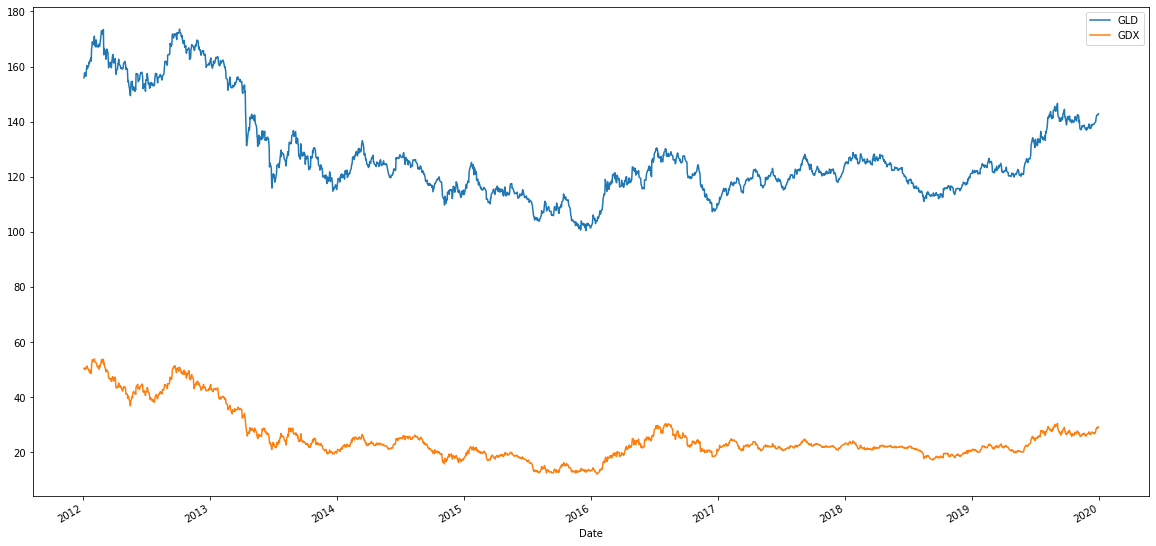

In [3]:
# get dataframe with adjusted close prices
gld_close = data['Adj Close']['GLD']
gdx_close = data['Adj Close']['GDX']
df = pd.concat([gld_close, gdx_close], axis=1, keys=['GLD', 'GDX'])
df

df.plot(figsize=(20, 10))

In [4]:
def dickey_fuller(x):
    stat, p, lags, obs, crit, t = adfuller(x)
    print(f'Augmented Dickey Fuller results {x.name}:')
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably not Stationary')
    else:
        print('Probably Stationary')


dickey_fuller(df['GLD'])
dickey_fuller(df['GDX'])

Augmented Dickey Fuller results GLD:
stat=-1.932, p=0.317
Probably not Stationary
Augmented Dickey Fuller results GDX:
stat=-2.758, p=0.065
Probably not Stationary


In [5]:
train_date = '2019-1-1'
GLD_train = gld_close.loc[gld_close.index < train_date].values.reshape(-1,1)
GDX_train = gdx_close.loc[gld_close.index < train_date]

[0.53761703]
-42.91054836091985


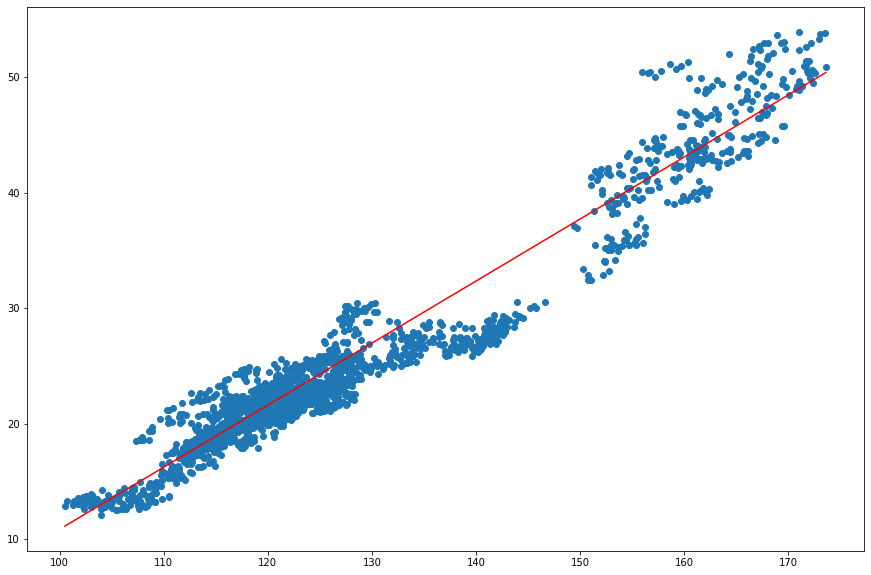

In [6]:
reg = LinearRegression()
reg.fit(GLD_train, GDX_train)
hedge_ratio = reg.coef_

# ploting prices
plt.figure(figsize=(15, 10))
plt.scatter(gld_close, gdx_close)

# plotting the trending line
x = np.array([gld_close.min(), gld_close.max()])
y = (lambda x: x*reg.coef_ + reg.intercept_)(x)
plt.plot(x, y, c='red')

print(reg.coef_)
print(reg.intercept_)

Augmented Dickey Fuller results GDX:
stat=-4.014, p=0.001
Probably Stationary


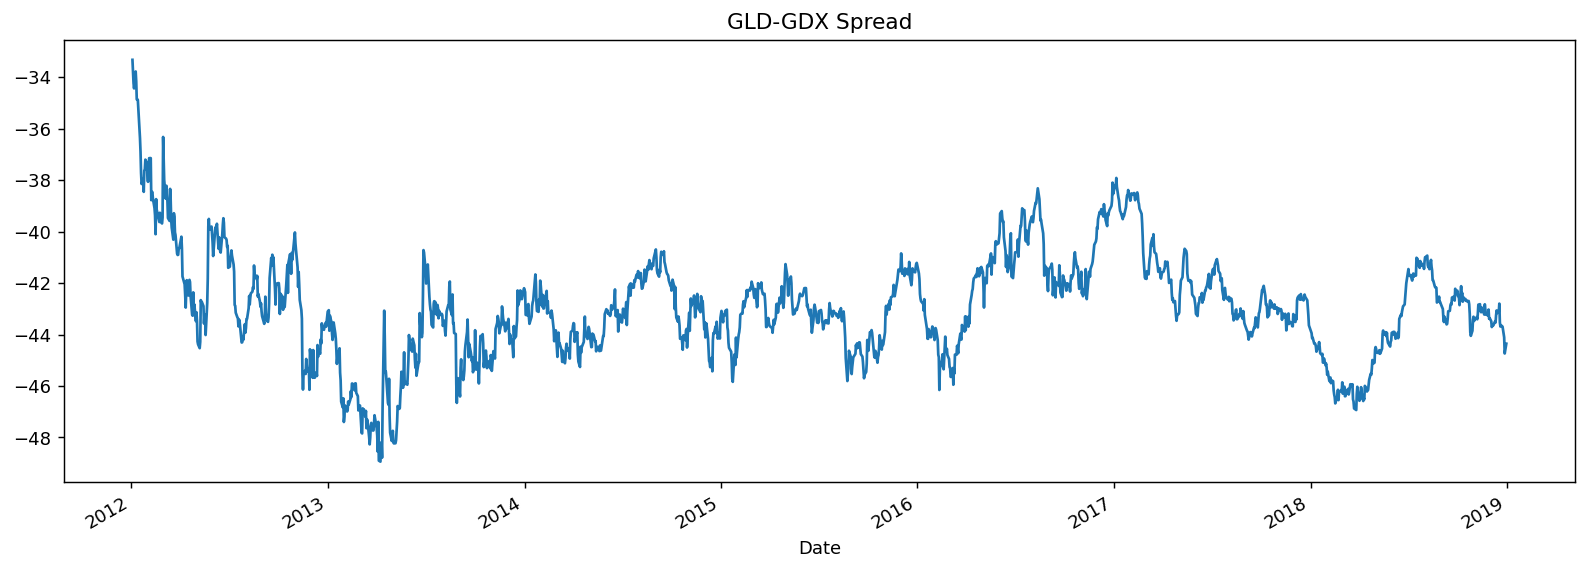

In [7]:
spreads = GDX_train - (GLD_train.reshape(1760) * hedge_ratio)
mpl.rcParams['figure.dpi'] = 130
plt.title('GLD-GDX Spread')
spreads.plot(figsize=(15, 5))

dickey_fuller(spreads)

In [11]:
train_date = '2019-1-1'
GLD_test = gld_close.loc[gld_close.index >= train_date].values.reshape(-1,1)
GDX_test = gdx_close.loc[gld_close.index >= train_date]
spreads = GDX_test - (GLD_test.reshape(252) * hedge_ratio)

In [12]:
spreads

Date
2019-01-02   -44.435840
2019-01-03   -44.602461
2019-01-04   -44.248026
2019-01-07   -44.730651
2019-01-08   -44.543362
                ...    
2019-12-24   -47.438024
2019-12-26   -47.616959
2019-12-27   -47.798985
2019-12-30   -47.343494
2019-12-31   -47.697553
Name: GDX, Length: 252, dtype: float64

In [ ]:
# create bollinger bands 
bb = ta.bollinger_band(spreads,)